# Intro

This notebook is a playground for building a knowledge graph for language. The idea is to use the Subject-Realtion-Object triplets extracted from natural langue text to build a knowledge graph. The knowledge graph can be used for many purposes, such as question answering, information retrieval, and so on.

For trining the triplets model, a special graph-embedding called RotatE will be used.

# Lib imports

In [1]:
import torch as th
import matplotlib.pyplot as plt
import lang_utils
import graph_utils 
import seaborn as sns
import pandas as pd
import pyvis as pv
import os
import networkx as nx
import torch_geometric.nn as tgnn
import torchviz

from pathlib import Path
from tqdm.auto import tqdm

# Data prep

For training the model we will utilize the article ["Trump vs. Biden: The biggest differences in their presidencies"](https://edyzoo.medium.com/trump-vs-biden-the-biggest-differences-in-their-presidencies-5f6aa055cf6a) by [Edy Zoo](https://edyzoo.medium.com/).

The article content has been extracted to txt file that can be found in a data folder.

In [2]:
article = open(Path(os.pardir, 'data', 'trump_vs_biden.txt'), "r").read()

## Entity extraction

First we need to extract the entities from the text. For this purpose we will use the SpaCy library.

1. Load the NLP model from SpaCy.
2. Turn into the SpaCy doc.
3. Extract the entities from the doc.
4. Post-process entities to extract only those, that are connected to people.

Make sure to have `en_core_web_md` dictionary installed for Spacy.

In [3]:
nlp = lang_utils.get_nlp()
doc = nlp(article)
entities = lang_utils.extract_person_entities(doc)
person_entities = lang_utils.merge_similar_entities(entities)

In [4]:
person_entities[:10]

['Biden', 'Donald Trump']

## Triplet extraction

Now we will perform some post-processing to clean and extract the triplets from the text.

In [5]:
person_triplets = lang_utils.extract_triplets_for_entities(doc, person_entities, nlp)

In [6]:
person_triplets[:10]

[('Biden', 'have had', 'very different approaches'),
 ('Donald Trump', 'taking', 'a more conservative and divisive stance'),
 ('Biden', 'emphasizing', 'the importance'),
 ('Biden', 'has been marked', 'a return'),
 ('Biden', 'have faced', 'challenges'),
 ('Biden', 'have faced', 'controversies'),
 ('Biden', 'has emphasized', 'the importance'),
 ('Donald Trump', 'pursued', 'a largely conservative agenda'),
 ('Donald Trump', 'roll', 'environmental regulations'),
 ('Donald Trump', 'cut', 'taxes')]

## Graph preparation

Person-related triplets can be represented as a graph visualization.

In [7]:
G = nx.DiGraph()

edges = {(s, o): r for s,r,o in person_triplets}
G.add_edges_from(edges.keys())
for (efrom, eto), label in edges.items():
    nx.set_edge_attributes(G, {(efrom, eto): label}, "label")
    
nt = pv.network.Network('1000px', '1000px', notebook=True, cdn_resources='in_line')
nt.from_nx(G)
nt.show('graph.html')

graph.html


# Model

# Model trianing prep

We need to map subject-rel-objects to numerical ids - they will be used in the model for embedding.

In [8]:
triplet_mapping = graph_utils.triplets2idx(person_triplets)
subject_ids, rel_ids, object_ids = graph_utils.build_triplets_tensors(triplet_mapping)

Now it is time to train some embedding models on the triplets. We will utilize RotatE model from PyTorch Geometric library.

In [9]:
model = tgnn.RotatE(len(triplet_mapping.elem2idx), num_relations=len(triplet_mapping.rel2idx), hidden_channels=8, margin=3)

Let's take a look on the model structure.

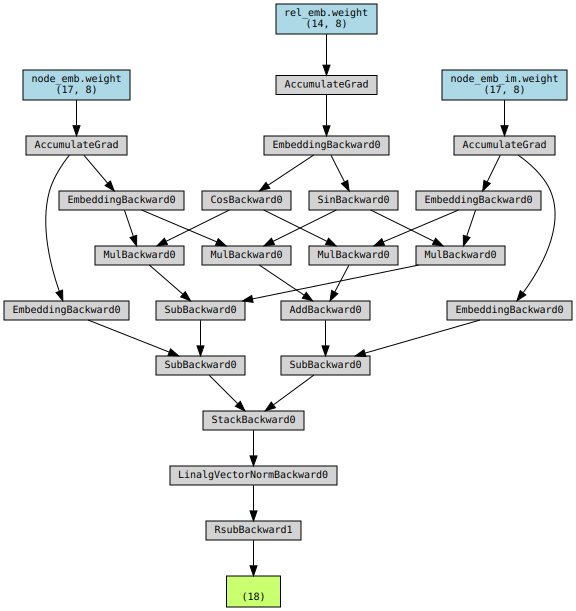

In [10]:
torchviz.make_dot(model(subject_ids, rel_ids, object_ids), params=dict(model.named_parameters()))

We will train the model semi-manually on the triplets. For educational clarity, we won't delegate everyting to e.g. PyTorch Lightning.

In [11]:
optim = th.optim.Adam(model.parameters(), 0.01)
loader = model.loader(
    head_index=subject_ids,
    rel_type=rel_ids,
    tail_index=object_ids,
    batch_size=8,
    shuffle=True
)

In [12]:
losses = []
epochs = 150
for ep in tqdm(range(epochs)):
    model.train()
    total_loss = total_examples = 0
    # Iterate in batches over the training dataset: sunbject-rel-object
    for head_index, rel_type, tail_index in loader:
        optim.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optim.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    avg_loss = total_loss / total_examples
    losses.append(avg_loss)

  0%|          | 0/150 [00:00<?, ?it/s]

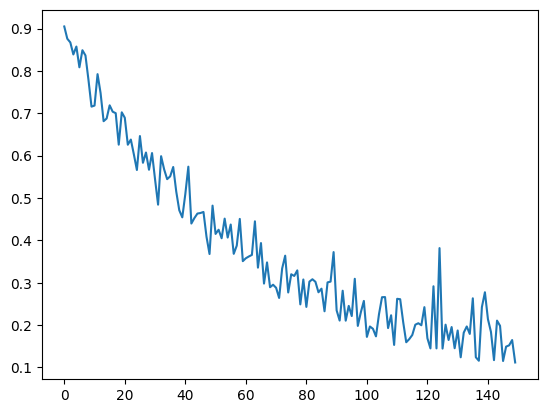

In [13]:
plt.plot(losses);

# Triplet embedding

Now we can do some predictive modelling. We will ask "queries" in a form of triplets with missing elements. Model will
find the missing element that best fits the query.

E.g.:

```[Donald Trump, is, ?] -> [Donald Trump, is, president]```

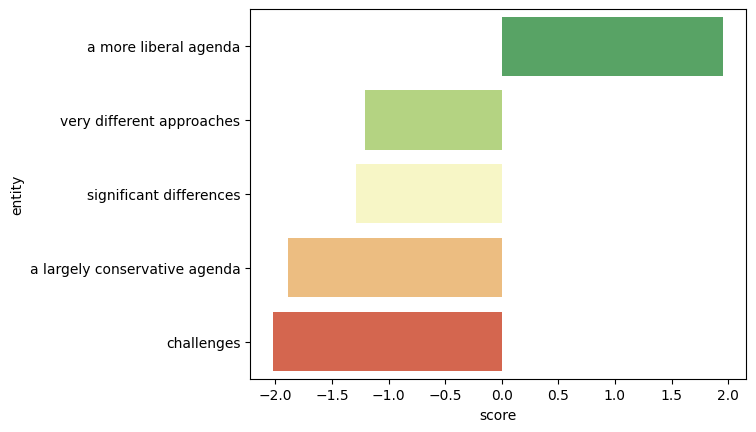

In [14]:
scores1 = graph_utils.analyze_sentence_soundness(model, triplet_mapping, subj="Trump", rel="pursued").sort_values(by='score', ascending=False)
sns.barplot(x="score", y="entity", data=scores1, palette='RdYlGn_r');

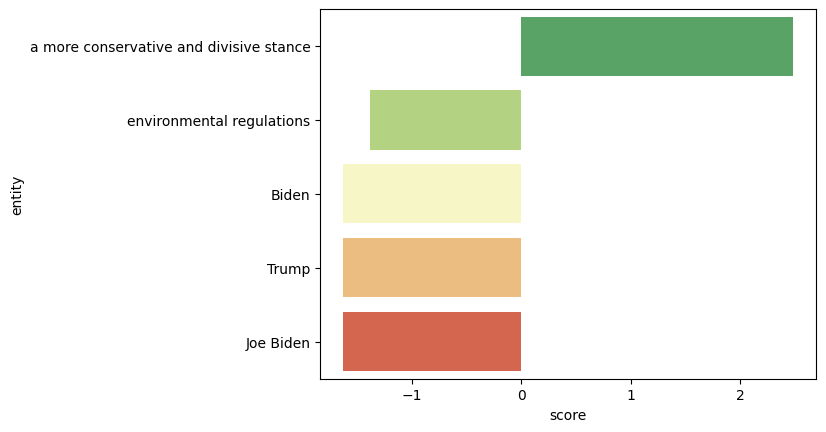

In [28]:
scores2 = graph_utils.analyze_sentence_soundness(model, triplet_mapping, subj='Donald Trump', rel='taking').sort_values(by='score', ascending=False)
sns.barplot(x="score", y="entity", data=scores2, palette='RdYlGn_r');